# Messages Monitoring Model

## Phase 1: Preprocessing the Data

### Load in the Required Libraries

In [158]:
# for dealing with data
import pandas as pd
import numpy as np
from datasets import load_dataset
import re

# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for processing data
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

# for evaluation metrics
from sklearn.metrics import accuracy_score

### Load in the Datasets

In [159]:
# download the kaggle datasets
# uncomment the following lines to download the datasets
# !kaggle datasets download -d uciml/sms-spam-collection-dataset
# !kaggle datasets download -d team-ai/spam-text-message-classification
# !wget https://raw.githubusercontent.com/DeshDSingh/SMS-SPAM-Detection/master/sms_spam.csv
# !unzip sms-spam-collection-dataset.zip
# !unzip spam-text-message-classification.zip
# !rm sms-spam-collection-dataset.zip
# !rm spam-text-message-classification.zip
# !mv sms_spam.csv ./../data

In [160]:
# read in the datasets
sms_data1 = pd.read_csv("../data/SPAM text message 20170820 - Data.csv")
sms_data2 = pd.read_csv("../data/spam.csv", encoding='latin-1')
sms_data3 = pd.DataFrame((load_dataset("sms_spam")['train']))
sms_data4 = pd.read_csv("./../data/sms_spam.csv")

Reusing dataset sms_spam (/Users/necro_kudo/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)
100%|██████████| 1/1 [00:00<00:00, 142.92it/s]


In [161]:
# unify the features names
sms_data1.rename({"Category": "label", "Message": "message"}, axis=1, inplace=True)
sms_data1 = sms_data1[["message", "label"]]

# unify the features names & drop unwanted features
sms_data2.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
sms_data2.rename({"v1" : "label", "v2" : "message"}, axis=1, inplace=True)
sms_data2 = sms_data2[["message", "label"]]

# unify the features names
sms_data3.rename({"sms" : "message"}, axis=1, inplace=True)
sms_data3['label'] = sms_data3['label'].apply(lambda x: "spam" if x == 1 else "ham")

# unify the features names
sms_data4.rename({"type" : "label", "text" : "message"}, axis=1, inplace=True)
sms_data4 = sms_data4[["message", "label"]]

In [162]:
# concatenate the results to form a bigger dataframe of all the previous ones
sms_big = pd.concat([sms_data1, sms_data2, sms_data3, sms_data4], axis=0)
sms_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22277 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  22277 non-null  object
 1   label    22277 non-null  object
dtypes: object(2)
memory usage: 522.1+ KB


Great! Since we concatenated the dataframes together, we need to check for duplicates if present, and drop them.

### Exploratory Data Analysis

In [163]:
# check for duplicates
print(f"Number of observations before dropping duplicates: {len(sms_big)}")
print(f"Number of duplicated observations: {sms_big.duplicated().sum()}")
sms_big.drop_duplicates(inplace=True)
print(f"Number of observations after dropping the duplicates: {len(sms_big)}")


Number of observations before dropping duplicates: 22277
Number of duplicated observations: 10579
Number of observations after dropping the duplicates: 11698


Even though the number of duplicates is alarming (almost 1/2 of the concatenated data), luckily, dropping them will leave us with still a large dataset of over 10K observations

In [164]:
# examine the number of observations for each class
sms_big.label.value_counts()

ham     10124
spam     1574
Name: label, dtype: int64

Before proceeding to examine the imbalance in our data, we will first clean it from unwanted characters

In [165]:
# clean the data by making it all lower-case and getting rid of special characters
for i in range(0,sms_big.shape[0]):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms_big.message.iloc[i]) 
    message = message.lower() 

We will start our data examination through:

- Getting to know the length of our messages
- Descriptive statistices

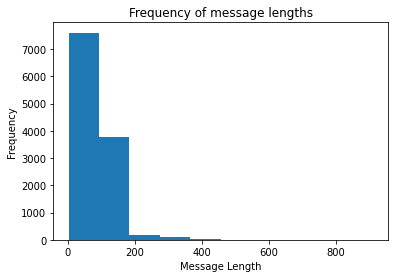

In [185]:
# finding the length of our messages
message_lengths = []
for row in range(0, len(sms_big)):
    message_lengths.append(len(sms_big.message.iloc[row]))
sms_big['length'] = message_lengths

## plot the count plot to show how frequent long and short messages are in the data
sms_big.length.plot.hist()

plt.title("Frequency of message lengths")
plt.xlabel("Message Length")
plt.ylabel("Frequency");

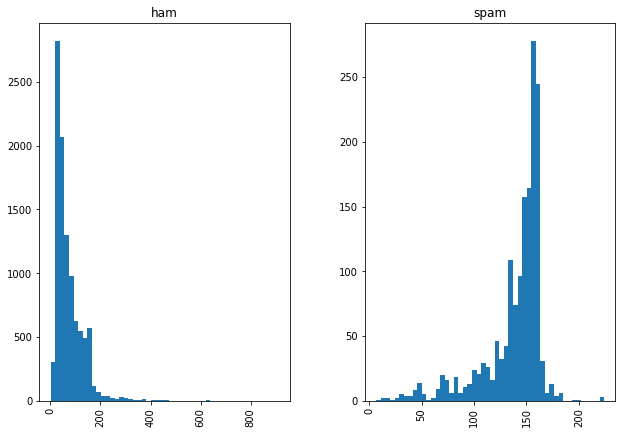

In [202]:
# plot per label
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7), sharex=True, sharey=True)
sms_big.hist(column='length', by='label', bins=50,figsize=(10,7));

# plt.xlabel("Message Length")
# plt.ylabel("Frequency")
# plt.show();

In [203]:
# descriptive statistcs of our data
sms_big.describe()

,length
count,11698.000000
mean,82.356471
std,59.660992
min,2.000000
25%,37.000000
50%,65.000000
75%,124.000000
max,911.000000


For each label:

In [211]:
print("Descriptive statistics for 'ham':\n")
sms_big[sms_big.label == 'ham'].describe()

Descriptive statistics for 'ham':



,length
count,10124.000000
mean,73.528842
std,58.334125
min,2.000000
25%,35.000000
50%,55.000000
75%,96.000000
max,911.000000


In [210]:
print("Descriptive statistics for 'spam':\n")
sms_big[sms_big.label == 'spam'].describe()

Descriptive statistics for 'spam':



,length
count,1574.000000
mean,139.135959
std,29.012974
min,7.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,224.000000


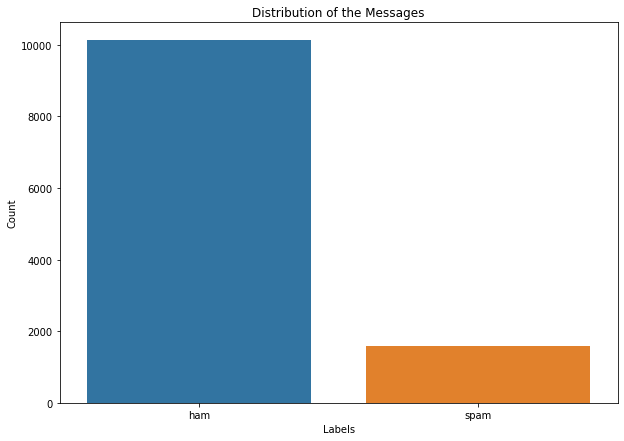

In [166]:
# plot the distribution of the examples in each class
plt.figure(figsize=(10,7))
sns.countplot(x='label', data=sms_big)

plt.title('Distribution of the Messages')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

We can see that our target class, `spam`, is imbalanced. Thus we would use `smote` to fix this issue.

In [167]:
# prepare smote instance along with data splits for oversampling
sm = SMOTEN(random_state=42)
X = sms_big.message
y = sms_big.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<AxesSubplot:xlabel='label', ylabel='count'>

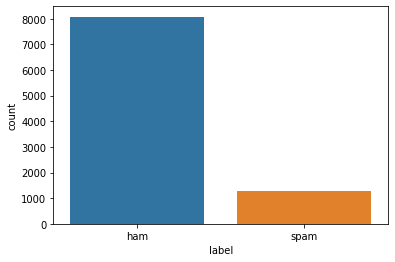

In [168]:
# training data before oversampling
train_df = pd.concat([X_train, y_train], axis=1)
sns.countplot(x='label', data=train_df)

<AxesSubplot:xlabel='1', ylabel='count'>

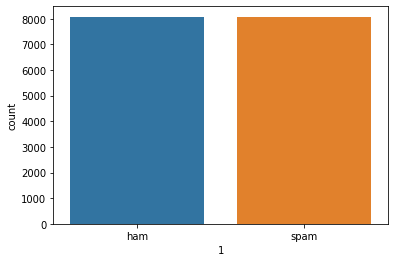

In [169]:
# training data after oversampling
X_res, y_res = sm.fit_resample(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
X_train_res = pd.Series(X_res.reshape(-1))
y_train_res = pd.Series(y_res.reshape(-1))
train_df = pd.concat([X_train_res, y_train_res], axis=1)
sns.countplot(x=1, data=train_df)

Now lets oversample the test set too

<AxesSubplot:xlabel='label', ylabel='count'>

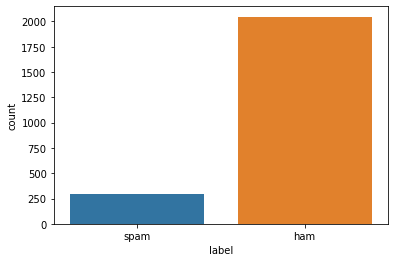

In [170]:
# testing set before oversampling
test_df = pd.concat([X_test, y_test], axis=1)
sns.countplot(x='label', data=test_df)

<AxesSubplot:xlabel='1', ylabel='count'>

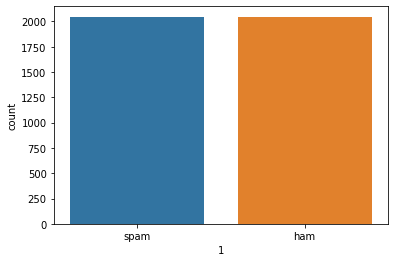

In [171]:
# testing data after oversampling
X_res, y_res = sm.fit_resample(np.array(X_test).reshape(-1,1), np.array(y_test).reshape(-1,1))
X_test_res = pd.Series(X_res.reshape(-1))
y_test_res = pd.Series(y_res.reshape(-1))
test_df = pd.concat([X_test_res, y_test_res], axis=1)
sns.countplot(x=1, data=test_df)